# Training a classifier
We will train a classier for the dataset CIFAR10 that contains images belonging to 10 different classes in two ways:
- training a CNN from scratch
- finetuning a CNN

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# define transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# define batch size
batch_size = 4

# load train ds
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# load test ds
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


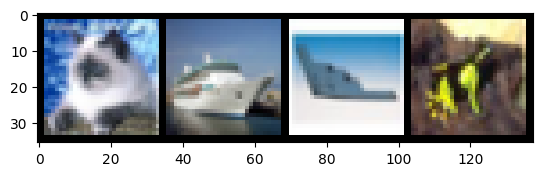

cat ship plane frog


In [12]:
# show some images
import matplotlib.pyplot as plt

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

to_pil = transforms.ToPILImage()

img, labels = next(iter(trainloader))

plt.imshow(to_pil(torchvision.utils.make_grid(denorm(img))))
plt.show()

# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
# Define a CNN to classify the images
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional block
        self.conv_block1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=5),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2))
        # second convolutional block
        self.conv_block2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2))
        # fully connected blocks
        self.fc1 = nn.Sequential(nn.Linear(16 * 5 * 5, 120),
                                nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [19]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
# TRAIN!
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.843
[1,  6000] loss: 1.662
[1,  8000] loss: 1.568
[1, 10000] loss: 1.502
[1, 12000] loss: 1.448
[2,  2000] loss: 1.375
[2,  4000] loss: 1.360
[2,  6000] loss: 1.321
[2,  8000] loss: 1.324
[2, 10000] loss: 1.287
[2, 12000] loss: 1.289
Finished Training


In [21]:
# if you want to save the model
PATH = './res/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [22]:
# if you want to load the model
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
# now lets evaluate the model on the test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


In [26]:
# Ex1: try to get the accuracy for each class

The classifier was able to correctly classify CIFAR10 with a good accuracy, but we can do much better!
HOW?